In [1]:
dataset_name = "W13_comb"
df_list = [
           "BES_Panel",
           "BES_reduced_with_na",
#            "BESnumeric"
#            "BES_reduced",
#            "BESnumeric"
          ]

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re
sns.set()
sns.palplot(sns.color_palette("colorblind"))
from IPython.display import display, display_html, HTML

import Jupyter_module_loader
from utility import *
import gaussian_kde


In [3]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
%matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()




In [4]:
global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

var_type (5173, 12)


In [5]:
from cycler import cycler
def nice_bar_plot(ser1, ser2, normalize = 'columns', sort_labels=False, output_folder = BES_output_folder,
                  text_width=8, text_fontsize=14, min_sample_size=100, title=None, drop_insig=True, fuckErrors=True,
                  mask=1, title_fontsize=14, color=None, label=None, char_limit=40):
    var1 = ser1.name
    var2 = ser2.name
    
    mask = ser1.notnull() & ser2.notnull() & mask
    ids = ser1[mask].index
    ser1 = ser1[mask]
    ser2 = ser2[mask]
#     ct = pd.crosstab( ser1, ser2,
#                       values= get_all_weights(mask), aggfunc=sum, normalize=normalize)*100
    ct = pd.crosstab( ser1, ser2,
                      values= get_all_weights(ids), aggfunc=sum, normalize=normalize)*100    
    if sort_labels:
        sorted_labels = list(ser2.value_counts().index)
    else:
        sorted_labels = list(ser2.cat.categories)
           

    unweighted = pd.crosstab( ser1, ser2 )
    errors = 100 * np.sqrt(unweighted)/unweighted     

    labels_by_sample_size = {unweighted.sum().values[x]:sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")" for x in range(0,len(sorted_labels))}    
    labels_by_sample_size = {sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")":unweighted.sum().values[x] for x in range(0,len(sorted_labels))}    
    labels_restricted = [x for x in labels_by_sample_size.keys() if labels_by_sample_size[x] > min_sample_size] 
#     return labels_by_sample_size, labels_restricted
    if drop_insig:
        rubbish_entries = ct<errors
        ct[rubbish_entries]=np.nan
        errors[rubbish_entries]=np.nan
#     return(sorted_labels, errors, labels_by_sample_size)
    all_nan_rows = ~errors.isnull().any(axis=1)
    errors.columns = list( labels_by_sample_size.keys() )
   
    ct.columns = list( labels_by_sample_size.keys() )
    ct = ct.loc[all_nan_rows, labels_restricted]
#     return errors, labels_restricted
    errors = errors.loc[all_nan_rows, labels_restricted]
#     errors=errors.T
#     return errors
#     return errors, ct
    treatment = var2 +" by " + var1
    output_subfolder = create_subdir(output_folder, treatment)
    import textwrap 

    wrapper = textwrap.TextWrapper(width=text_width) 

    stacked = ct.stack().reset_index().rename(columns={0:'%',"level_1":var2})
    err_stacked = errors.stack().reset_index().rename(columns={0:'%',"level_1":var2})
    fig = plt.figure(figsize=(20, 8))
    ax = fig.subplots()

#     a = [np.ones(16),np.ones(16)]
#     a = errors.values
#     return a
#     iter(a)    
    
    stacked[var1] = stacked[var1].apply( lambda x: x +" (N="+str(unweighted.sum(axis=1).loc[x])+")" )
    stacked[var1].cat.set_categories(stacked[var1].cat.categories[all_nan_rows],inplace=True)
#     return stacked
#     return stacked['%'].shape,err_stacked["%"].values.reshape(len(stacked),1).shape
    if fuckErrors:
        bar = sns.barplot(x = stacked[var2],
                    y = stacked['%'],
                    hue = stacked[var1],
                    ax = ax, order = labels_restricted);
    else:
        bar = sns.barplot(x = stacked[var2],
                    y = stacked['%'],
                    hue = stacked[var1],
                    ax = ax, order = labels_restricted,
                    yerr = errors.values);        
                    # err_stacked["%"].values );
# .reshape(len(stacked),1)

#     hatch_cycle = cycler(hatch=['/', '*', '-','+','x','\\','o' '|'])
    # Define some hatches
#     hatches = ['-', '+', 'x', '\\', '*', 'o']
    hatch_cycle = cycle(['/', '*', '-','+','x','\\','o', '|'])
    # Loop over the bars
    for i,thisbar in enumerate(bar.patches):
        # Set a different hatch for each bar
        thisbar.set_hatch(next(hatch_cycle))

    if title is None:
        title = var2 +" by " + var1
    plt.title(title, fontsize=title_fontsize)
    sorted_labels = [sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")" for x in range(0,len(sorted_labels))]
    ax.set_xticklabels([ wrapper.fill(text=x) for x in labels_restricted], rotation=0, fontsize=text_fontsize);

    ax.annotate(dataset_citation, (0,0), (0, -140),
                     xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ;           
    fname = output_subfolder + clean_filename(title, char_limit = char_limit) + ".png"
    fig.savefig( fname, bbox_inches='tight' )    

In [6]:
def get_all_weights(ids, specific_wave = None):

    if specific_wave is None:
        wts = BES_Panel.loc[ids, list(num_to_weight.values())]
    else:
        wts = BES_Panel.loc[ids, specific_wave]
    # wts.hist(bins=100,figsize=(16,12));

    wts = wts/wts.mean()
    # wts.mean(axis=1).hist(bins=100,figsize=(16,12));
    # # wts = wts/wts.mean(axis=1)
    wts = wts.mean(axis=1)
    wts =wts/wts.mean()
    return wts
# wts

In [7]:
def sort_by_wave(lst):
    dict_by_wave = {int(x.split("W")[-1]):x for x in lst}
    return [dict_by_wave[x] for x in sorted(dict_by_wave.keys())]
    
max_wave, num_to_wave, num_to_weight, weights = get_weights(dataset_name,BES_Panel)

In [8]:
pan_dataset_ages = pd.read_msgpack(    BES_small_data_files + "pan_dataset_ages"+".msgpack" )
pan_dataset_allr_values = pd.read_csv( BES_small_data_files + "pan_dataset_allr_values"+".csv" )

In [9]:

       
# transform a column of data until it's as approximately normally distributed as can be
# because most Machine Learning/Statistical methods assume data is ~normally distributed
# basically, what people normally do randomly logging/square-rooting data, only automatically

from scipy import stats
def box_cox_normalise(ser, offset = 3, bw='scott'):
    
    
    # box cox lr_scale
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    x = ser.values +ser.values.min()+offset
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot against normal distribution')
    ax2 = fig.add_subplot(312)
    xt, _ = stats.boxcox(x)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title('Probplot after Box-Cox transformation')
    ax3 = fig.add_subplot(313)
    xt_std = (xt-xt.mean())/xt.std()
    sns.kdeplot(xt_std, ax=ax3, bw=bw, cut=0);
    sns.kdeplot(np.random.normal(size=len(xt_std)), ax=ax3, cut=0);
    plt.suptitle(ser.name)
    return xt_std
    

def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j),X.loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
    print(df.sort_values(by='corr',ascending=False).dropna())
    
    
# messy but time saver
    
   
import shap
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

def shap_outputs(shap_values, train, target_var, output_subfolder,
                 dependence_plots = False, threshold = .1, min_features = 30,
                 title=None):

    #################################
#     threshold = .1
#     min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )
#     if n_top_features <min_features:
#         n_top_features = min_features

    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.title(target_var);
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    if title is None:
        fig.suptitle(target_var);
    else:
        fig.suptitle(title);
        
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            clean_filename(name)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + clean_filename(name) + ".png", bbox_inches='tight')
            count = count + 1
            
def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights = None ):

    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )

        eval_set = [(X_test, y_test)]

        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )
          
            

        eval_set = [(X_test, y_test)]

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True )        
        

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)            
    
global var_list, mask
def xgboost_run(title, subdir=None, min_features=30, dependence_plots=False , output_folder=".."+os.sep+"Output"+os.sep,Treatment="default"):
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(output_folder,Treatment)

    for target_var in var_list:
        if sample_wts:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(target_var)
        mask   = target.notnull()
        if optional_mask & sample_wts:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            continue

        train = create_train(drop_other_waves)[mask]

        if subdir is None:
            output_subfolder = create_subdir(treatment_subfolder,target_var)
        else:
            output_subfolder = create_subdir(treatment_subfolder,subdir)

        if sample_wts:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                                  sample_weights=sample_weights )
        # fit to full dataset at non-overfitting level
        alg.fit(train, target, verbose = True, sample_weight = sample_weights)


    #################

        explainer = shap.TreeExplainer(alg)
        shap_values = explainer.shap_values(train)
        
#         shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1,
                     min_features = min_features, title=title,
                     dependence_plots=dependence_plots)
        
    return (explainer, shap_values)







############################ BASIC SETTINGS

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    
optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
    return 1



def create_train(drop_other_waves):
    keep_list = df.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return df[keep_list]


def create_target(target_var):
    
    return df[target_var]

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 508,
 max_depth=6,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.6,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=5e-05,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)





In [13]:
BES_reduced_with_na[search(BES_reduced_with_na,"subjClass|ns_sec|socialgrade").index].corrwith(BES_reduced_with_na["profile_eurefvote_Leave the EU"])

profile_socialgrade_cieW7__E                                                                  0.173286
profile_socialgrade_cieW8__E                                                                  0.163260
profile_socialgrade_cieW12__E                                                                 0.158000
profile_socialgrade_cieW13__E                                                                 0.160006
profile_socialgrade_cie__E                                                                    0.209306
subjClassW10_Yes, working class                                                               0.126326
subjClassW10_Yes, middle class                                                               -0.130841
subjClassW10_No                                                                              -0.002769
subjClassW12_Yes, working class                                                               0.118337
subjClassW12_Yes, middle class                                           

In [25]:
BES_Panel["Age"].notnull().sum()

66643

In [26]:
Retired = (BES_Panel["workingStatusW1W2W3W4W5"]=="Retired") | (BES_Panel["workingStatusW6_W12"]=="Retired")
Young = BES_Panel["Age"]<=40

BES_reduced_with_na[search(BES_reduced_with_na,"subjClass|ns_sec|socialgrade").index][Young].corrwith(BES_reduced_with_na["profile_eurefvote_Leave the EU"][Young])

profile_socialgrade_cieW7__E                                                                  0.157913
profile_socialgrade_cieW8__E                                                                  0.160813
profile_socialgrade_cieW12__E                                                                 0.159504
profile_socialgrade_cieW13__E                                                                 0.162193
profile_socialgrade_cie__E                                                                    0.175486
subjClassW10_Yes, working class                                                               0.139084
subjClassW10_Yes, middle class                                                               -0.159589
subjClassW10_No                                                                               0.018614
subjClassW12_Yes, working class                                                               0.140816
subjClassW12_Yes, middle class                                           

In [33]:
BES_reduced_with_na[search(BES_reduced_with_na,"housing|tenure").index].corrwith(BES_reduced_with_na["profile_eurefvote_Leave the EU"]).sort_values()

profile_house_tenureW11_Rent - from a private landlord                                                         -0.084879
profile_house_tenure_Rent from a private landlord                                                              -0.084493
profile_house_tenureW10_Rent from a private landlord                                                           -0.081073
profile_house_tenureW12_Rent - from a private landlord                                                         -0.080586
profile_house_tenureW13_Rent - from a private landlord                                                         -0.078261
miilabelW5_housing                                                                                             -0.076846
housing_Rented from private landlord                                                                           -0.076827
profile_house_tenureW13_Neither - I live rent-free with my parents, family or friends                          -0.073725
profile_house_tenureW10_Neither 

16522

In [32]:
search(BES_reduced_with_na,"housing|tenure")

miilabelW1_housing                                                                                              22760
miilabelW2_housing                                                                                              22144
miilabelW3_housing                                                                                              19537
miilabelW4_housing                                                                                              24379
miilabelW5_housing                                                                                              24833
miilabelW6_housing                                                                                              22215
housing_Own the leasehold/freehold outright                                                                     30635
housing_Buying leasehold/freehold on a mortgage                                                                 30635
housing_Rented from private landlord                    

In [17]:
search(BES_Panel,"euref").sort_values()

euRefVoteHypotheticalW9       1788
euRefVoteSqueezeW8            3818
euRefVotePostW8               4326
euRefVoteSqueezeW7            4717
euRefVoteW2                  25798
euRefVoteW3                  27830
euRefpastVoteW11             28008
euRefVoteW9                  28248
euRefpastVoteW13             28298
euRefCertaintyW8             29174
euRefVote2W8                 29175
euRefTurnoutW8               29175
euRefVoteUnsqueezeW8         29175
goodConductEURefW9           30036
euRefTurnoutRetroW9          30036
euRefFinalPostW9             30036
euRefVoteW6                  30148
euRefVoteW10                 30319
expectGoodConductEURefW10    30319
euRefDoOverW10               30319
euRefVoteW1                  30325
euRefInterestW7              30895
euRefTurnoutW7               30895
euRefVoteUnsqueezeW7         30895
expectGoodConductEURefW7     30895
euRefFinalW7                 30895
euRefExpectationW7           30895
euRefVoteW7                  30895
euRefTurnoutRetroW11

In [14]:
ResidentInWales = BES_Panel["country"]=="Wales"


In [15]:
BES_Panel["countryOfBirth"][ResidentInWales].value_counts()

Wales                                   2378
England                                 1636
Other: European Union member country      56
Scotland                                  52
Other: Rest of world                      50
Other: Commonwealth member country        43
Prefer not to answer                      27
Northern Ireland                          17
Republic of Ireland                       13
Name: countryOfBirth, dtype: int64

In [24]:
ct = pd.crosstab( BES_Panel["countryOfBirth"][ResidentInWales], BES_Panel["profile_eurefvote"][ResidentInWales],
                      values= get_all_weights(BES_Panel["countryOfBirth"][ResidentInWales].index), aggfunc=sum, normalize='index')*100
ct.loc[["England","Wales"]]

profile_eurefvote,Stay/remain in the EU,Leave the EU,Don't know
countryOfBirth,,,
England,51.693251,47.769433,0.537316
Wales,53.869073,45.292722,0.838205


In [29]:
ct = pd.crosstab( Welshness[ResidentInWales], BES_Panel["profile_eurefvote"][ResidentInWales],
                      values= get_all_weights(BES_Panel[ResidentInWales].index), aggfunc=sum, normalize='index')*100
ct

profile_eurefvote,Stay/remain in the EU,Leave the EU,Don't know
welshnessW1&2&3&4&7&8&9&10&11&12&13,,,
Not at all Welsh,47.499240,51.718375,0.782385
2,57.451426,41.370450,1.178125
3,67.321584,32.593189,0.085227
4,54.389890,44.783862,0.826248
5,56.957196,42.046824,0.995980
6,59.955885,39.198298,0.845818
Very strongly Welsh,48.471801,50.831825,0.696374
Don't know,71.901648,28.098352,0.000000


In [30]:
ct = pd.crosstab( BES_Panel["welshnessW2"][ResidentInWales], BES_Panel["profile_eurefvote"][ResidentInWales],
                      values= get_all_weights(BES_Panel[ResidentInWales].index), aggfunc=sum, normalize='index')*100
ct

profile_eurefvote,Stay/remain in the EU,Leave the EU,Don't know
welshnessW2,,,
Not at all Welsh,48.962123,50.475700,0.562177
2,54.460718,45.539282,0.000000
3,51.345214,48.495627,0.159158
4,47.048039,52.391154,0.560807
5,60.159872,39.347709,0.492419
6,60.769569,37.796089,1.434342
Very strongly Welsh,50.866851,48.639990,0.493159
Don't know,43.820710,56.179290,0.000000


In [31]:
ct = pd.crosstab( Englishness[ResidentInWales], BES_Panel["profile_eurefvote"][ResidentInWales],
                      values= get_all_weights(BES_Panel[ResidentInWales].index), aggfunc=sum, normalize='index')*100
ct

profile_eurefvote,Stay/remain in the EU,Leave the EU,Don't know
englishnessW1&2&3&4&7&8&9&10&11&12&13,,,
Not at all English,55.628303,43.593289,0.778409
2,56.877057,42.849416,0.273527
3,60.720906,38.947154,0.331940
4,54.492753,44.538502,0.968745
5,51.132897,47.780938,1.086165
6,52.546466,47.388595,0.064939
Very strongly English,34.551291,64.517386,0.931323
Don't know,52.313145,44.224885,3.461969


In [36]:
ct = pd.crosstab( Britishness[ResidentInWales], BES_Panel["profile_eurefvote"][ResidentInWales],
                      values= get_all_weights(BES_Panel[ResidentInWales].index), aggfunc=sum, normalize='index')*100
ct

profile_eurefvote,Stay/remain in the EU,Leave the EU,Don't know
britishnessW1&2&3&4&7&8&9&10&11&12&13,,,
Not at all British,67.066859,32.933141,0.000000
2,81.001354,18.998646,0.000000
3,67.644972,32.355028,0.000000
4,58.833730,40.436763,0.729508
5,63.596446,35.571253,0.832300
6,57.087491,42.656140,0.256369
Very strongly British,39.244173,59.564140,1.191687
Don't know,80.066437,19.933563,0.000000


In [46]:
ct = pd.crosstab( BES_Panel["speakWelshW1_W4W7W9_W12"][ResidentInWales], BES_Panel["profile_eurefvote"][ResidentInWales],
                      values= get_all_weights(BES_Panel[ResidentInWales].index), aggfunc=sum, normalize='index')*100
ct

profile_eurefvote,Stay/remain in the EU,Leave the EU,Don't know
speakWelshW1_W4W7W9_W12,,,
No,50.145933,49.099842,0.754226
"Yes, but not fluently",54.776735,44.306485,0.916780
"Yes, fluently",62.975774,36.520589,0.503637
Don't know,88.103378,11.896622,0.000000


In [26]:
Welshness = amalgamate_waves(BES_Panel,"welshness")

Englishness = amalgamate_waves(BES_Panel,"englishness")

Britishness = amalgamate_waves(BES_Panel,"britishness")

Scottishness = amalgamate_waves(BES_Panel,"scottishness")
ResidentInScotland = BES_Panel["country"]=="Scotland"
ResidentInWales = BES_Panel["country"]=="Wales"

Amalgamating variables: 
{1: 'welshnessW1', 2: 'welshnessW2', 3: 'welshnessW3', 4: 'welshnessW4', 7: 'welshnessW7', 8: 'welshnessW8', 9: 'welshnessW9', 10: 'welshnessW10', 11: 'welshnessW11', 12: 'welshnessW12', 13: 'welshnessW13'} ['welshnessW1', 'welshnessW2', 'welshnessW3', 'welshnessW4', 'welshnessW7', 'welshnessW8', 'welshnessW9', 'welshnessW10', 'welshnessW11', 'welshnessW12', 'welshnessW13']


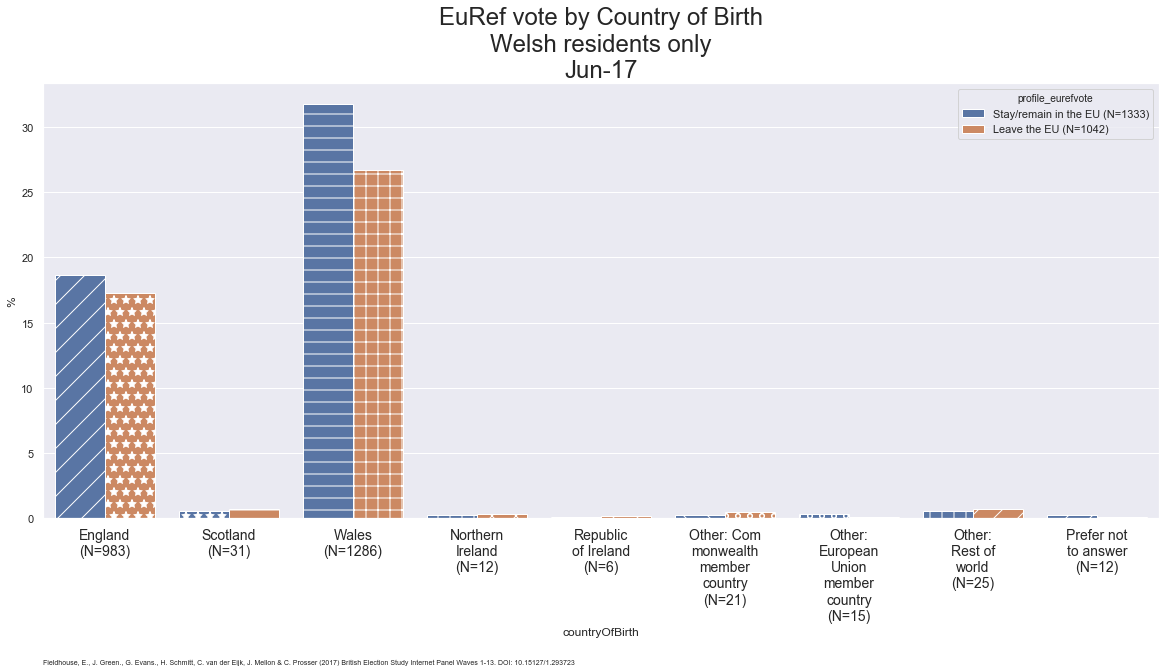

In [49]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0

wave = 13

var2 ="countryOfBirth"
var1 ="profile_eurefvote"

mask = ResidentInWales

# df2 = govtHandouts
df2 = BES_Panel[var2][mask]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1][mask]
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="EuRef vote by Country of Birth"+"\n"+"Welsh residents only"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

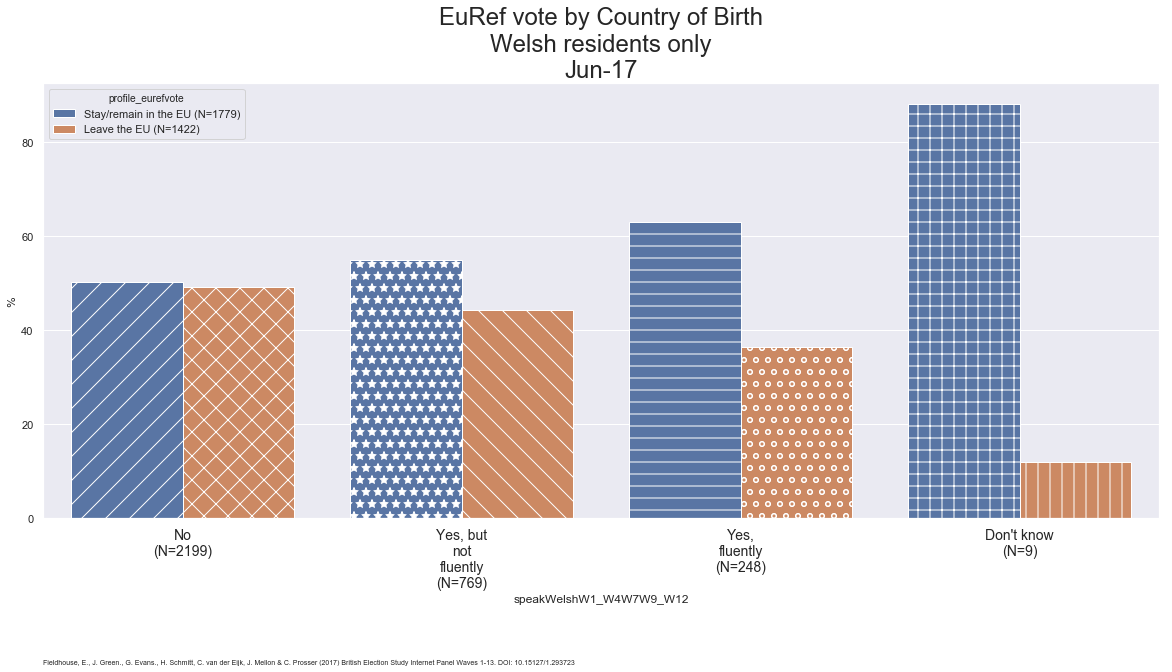

In [51]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0

wave = 13

var2 ="speakWelshW1_W4W7W9_W12"
var1 ="profile_eurefvote"

mask = ResidentInWales

# df2 = govtHandouts
df2 = BES_Panel[var2][mask]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1][mask]
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="EuRef vote by Country of Birth"+"\n"+"Welsh residents only"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

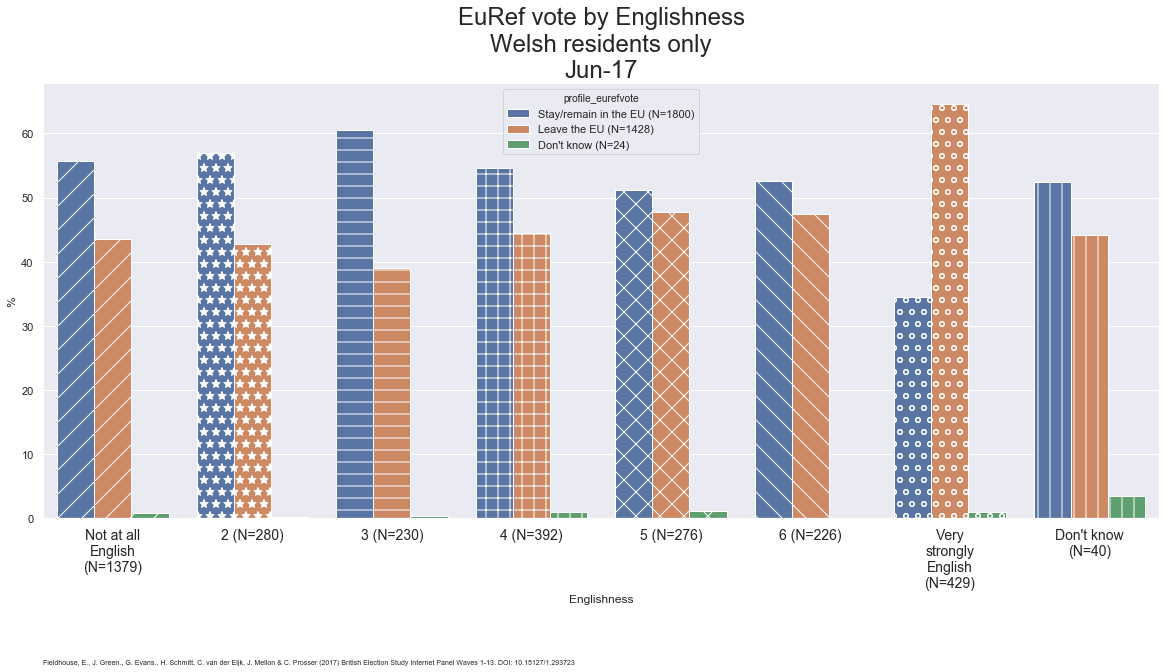

In [52]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0

wave = 13

var2 ="Englishness"
var1 ="profile_eurefvote"

mask = ResidentInWales

# df2 = govtHandouts
df2 = Englishness[mask]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1][mask]
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="EuRef vote by Englishness"+"\n"+"Welsh residents only"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

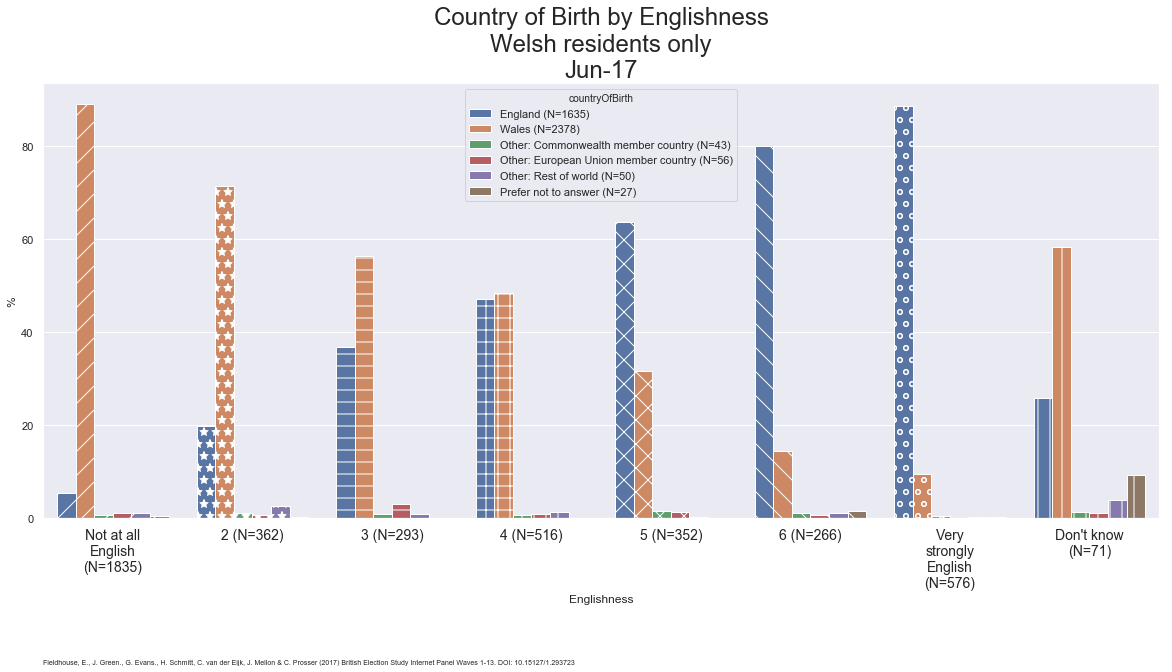

In [54]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0

wave = 13

var2 ="Englishness"
var1 ="countryOfBirth"

mask = ResidentInWales

# df2 = govtHandouts
df2 = Englishness[mask]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1][mask]
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="Country of Birth by Englishness"+"\n"+"Welsh residents only"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

In [65]:
list(BES_Panel[var1][mask].value_counts().index)

# BES_Panel[var1][mask].apply(lambda x: x.replace("|".join( ['Other: European Union member country', 'Scotland', 'Other: Rest of world', 'Other: Commonwealth member country', 'Prefer not to answer', 'Northern Ireland', 'Republic of Ireland'] ),"")).value_counts()


Wales      2378
England    1636
Name: countryOfBirth, dtype: int64

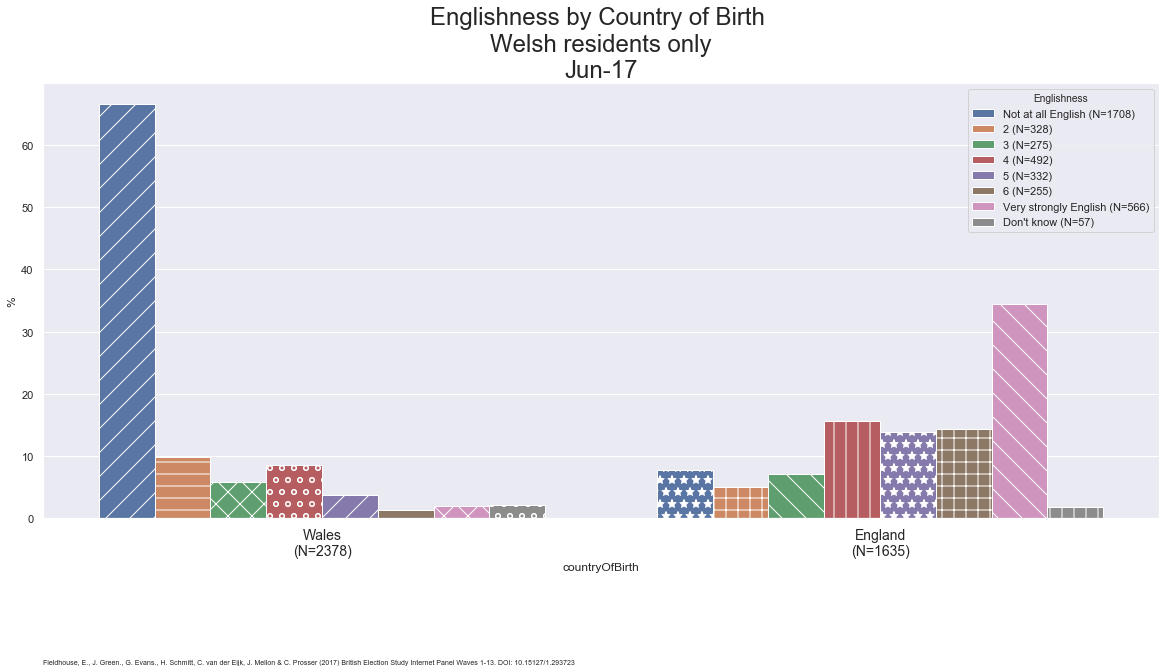

In [66]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0

wave = 13

var2 ="Englishness"
var1 ="countryOfBirth"

mask = ResidentInWales

# df2 = govtHandouts
df2 = Englishness[mask]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1][mask].cat.set_categories(["Wales","England"])
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df2, df1, min_sample_size=1, normalize='columns',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="Englishness by Country of Birth "+"\n"+"Welsh residents only"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

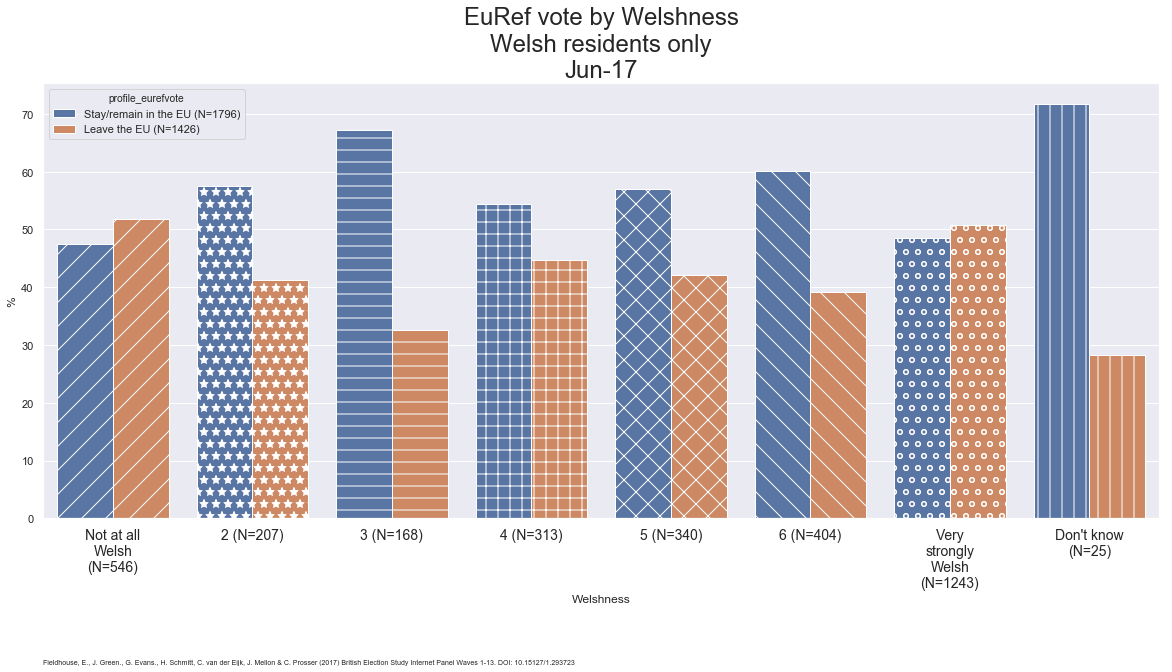

In [53]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0

wave = 13

var2 ="Welshness"
var1 ="profile_eurefvote"

mask = ResidentInWales

# df2 = govtHandouts
df2 = Welshness[mask]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1][mask]
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="EuRef vote by Welshness"+"\n"+"Welsh residents only"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

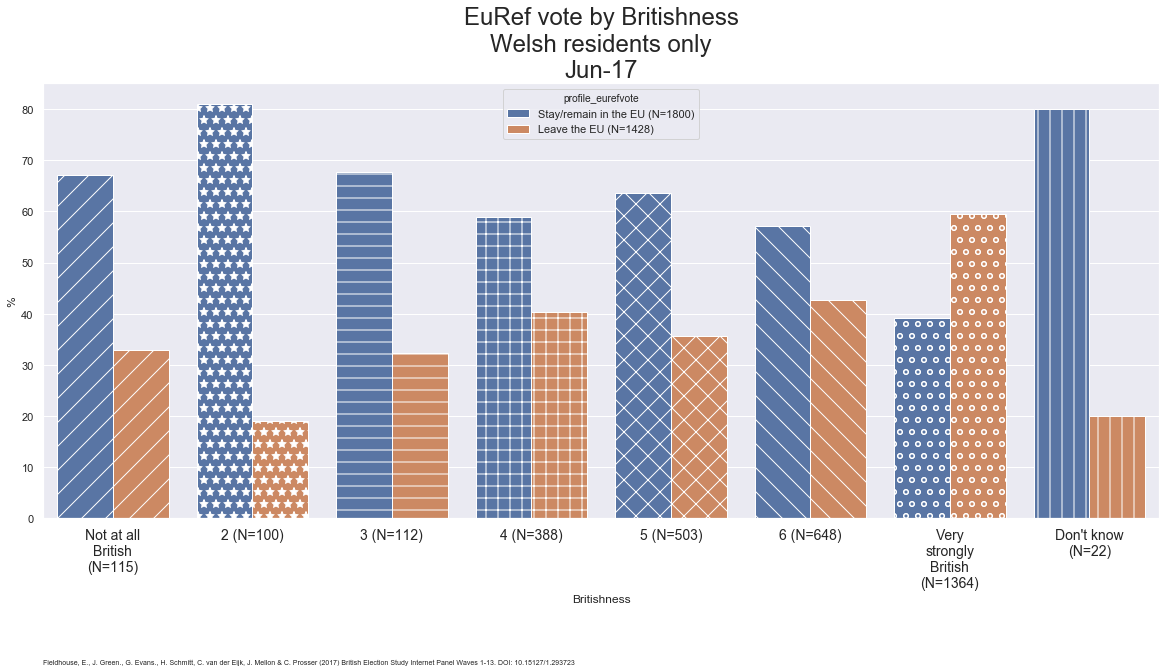

In [96]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0

wave = 13

var2 ="Britishness"
var1 ="profile_eurefvote"

mask = ResidentInWales

# df2 = govtHandouts
df2 = Britishness[mask]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1][mask]
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="EuRef vote by Britishness"+"\n"+"Welsh residents only"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

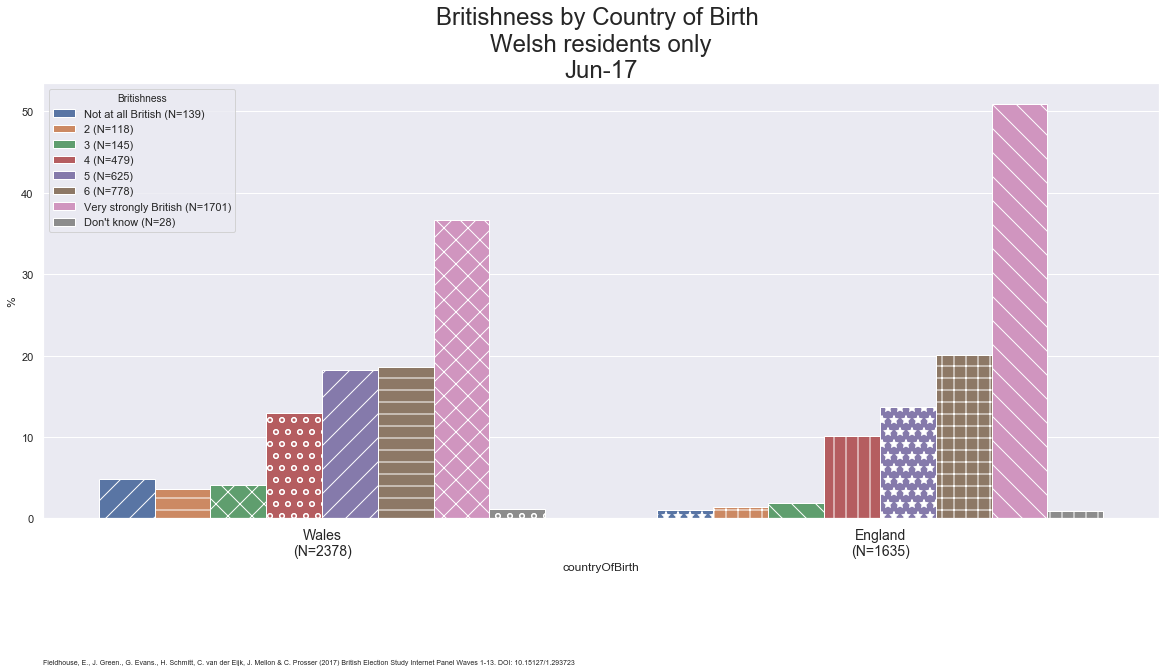

In [97]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0

wave = 13

var2 ="Britishness"
var1 ="countryOfBirth"

mask = ResidentInWales

# df2 = govtHandouts
df2 = Britishness[mask]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1][mask].cat.set_categories(["Wales","England"])
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df2, df1, min_sample_size=1, normalize='columns',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="Britishness by Country of Birth "+"\n"+"Welsh residents only"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

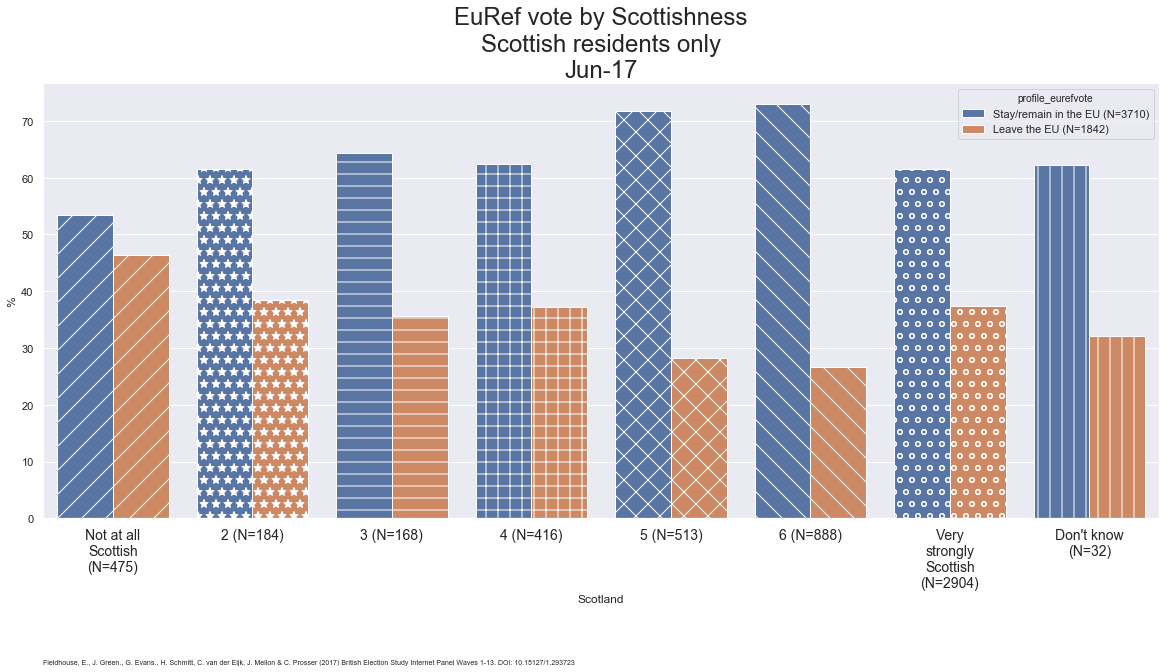

In [98]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0

wave = 13

var2 ="Scotland"
var1 ="profile_eurefvote"

# Scottishness = amalgamate_waves(BES_Panel,"scottishness")
# ResidentInScotland = BES_Panel["country"]=="Scotland"


mask = ResidentInScotland

# df2 = govtHandouts
df2 = Scottishness[mask]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1][mask]
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="EuRef vote by Scottishness"+"\n"+"Scottish residents only"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

In [44]:
search(BES_Panel,"speak")

accessFluentSpeakerW3       7039
britSpeakEnglishW11        31014
speakWelshW1_W4W7W9_W12     5487
dtype: int64

In [41]:
search(BES_reduced_with_na,"country")

country_England                                                                   66800
countryOfBirth_England                                                            36365
countryOfBirth_Scotland                                                           36365
countryOfBirth_Wales                                                              36365
countryOfBirth_Other: European Union member country                               36365
countryOfBirth_Other: Rest of world                                               36365
countryOfBirth_Other: Commonwealth member country                                 36365
countryOfBirth_Republic of Ireland                                                36365
countryOfBirth_Northern Ireland                                                   36365
scotReferendumOutsideW1_Scotland should become an independent country             20645
abroadCountry_1W8_Yes                                                              5214
abroadCountry_2W8_Yes           

In [39]:
# df["amalgamted_enviroprotection"] = amalgamate_waves(BES_reduced_with_na,"enviroProtection")

pattern = "profile_eurefvote_Leave the EU|euRefVote"
name = "profile_eurefvote_Leave the EU"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na[BES_Panel["country"]=="Wales"], name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
euRefVoteW9_Leave the EU,1,0.00,2148
euRefpastVoteW12_Leave the EU,0.97,0.00,2255
euIDW9_The leave side,0.96,0.00,2074
euRefVoteUnsqueezeW8_Leave the EU,0.91,0.00,1734
euRefVote2W8_Leave the EU,0.89,0.00,1820
happyEULeaveW9__Extremely happy,0.87,0.00,2132
EUIntegrationSelfW9__Protect our independence,0.81,0.00,2090
effectsEUEconW8__Much better,0.75,0.00,2042
euUndermineIdentityW8__Strongly agree,0.73,0.00,2120
euPriorityBalanceW13__Control immigration,0.71,0.00,1891


In [43]:
BES_reduced_with_na[BES_Panel["country"]=="Wales"]["countryOfBirth_England"].corr( BES_reduced_with_na[BES_Panel["country"]=="Wales"]["profile_eurefvote_Leave the EU"] )

0.008663146539460126

In [42]:
# Treatment = "xgboost_dealVnodeal"
# var_stub = "dealVnodeal"

# var_list = ["dealVnodeal_Leave without a deal"]
# var_stub_list = [var_stub,"euRefVote_Leave the EU","euID_The leave side","dealVremain_Remain in the EU",
#                  "delayOrNoDeal_Delay Brexit until parliament can agree a deal","euRefDoOver_Yes","cancelBrexit__Strongly agree",
#                  "euRefpastVote_Leave the EU","pastvote_EURef_Leave the EU",
#                  "willOfPeople__Strongly agree","dealVnodeal_Leave without a deal","profile_eurefvote_Leave the EU",
#                  "regretsIHaveAFewEU__I did not vote", 'noDealShortTerm__Extremely good', 'noDealLongTerm__Extremely good',
#                  "remainVnodeal_Remain in the EU"]

Treatment = "xgboost_welsh_Leave"
var_stub = "eurefvote"
var_list = ["profile_eurefvote_Leave the EU"]
var_stub_list = [var_stub]


# ImmigDiff = get_diff(["likeCorbyn"])#.notnull().sum()

# var_list = ImmigDiff.columns

# ["profile_education_age","workingStatus","profile_work_stat",]

optional_mask = True
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
#     return 1
    return (BES_Panel["country"]=="Wales")
#     return (BES_Panel["profile_eurefvote"]=='Stay/remain in the EU')
#     return (BES_Panel["profile_past_vote_2017"]=="Labour")



def create_train(drop_other_waves):
    
    keep_list = search(BES_reduced_with_na,"speakWelsh|countryOfBirth|Mean_welshness|Mean_englishness|Mean_britishness|englishness_minus_welshness|britishness_minus_englishness|britishness_minus_welshness").index
#     keep_list = search(BES_reduced_with_na,"subjClass|ns_sec|socialgrade|anyUni|profile_education_age|subjectHE|edlevel|countryOfBirth|englishness|britishness|welshness|speakWelsh|profile_work_stat|workingStatus").index
    #BES_reduced_with_na.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return BES_reduced_with_na[keep_list]


def create_target(target_var):
    
    return BES_reduced_with_na[target_var]

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.01,
 n_estimators= 1800,
 max_depth=10,
 min_child_weight=6,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.7,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=0.01,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)



[0]	validation_0-rmse:0.499352
Will train until validation_0-rmse hasn't improved in 180.0 rounds.
[1]	validation_0-rmse:0.498989
[2]	validation_0-rmse:0.498475
[3]	validation_0-rmse:0.49799
[4]	validation_0-rmse:0.497482
[5]	validation_0-rmse:0.496925
[6]	validation_0-rmse:0.4964
[7]	validation_0-rmse:0.495863
[8]	validation_0-rmse:0.495313
[9]	validation_0-rmse:0.494812
[10]	validation_0-rmse:0.494391
[11]	validation_0-rmse:0.494048
[12]	validation_0-rmse:0.493666
[13]	validation_0-rmse:0.493305
[14]	validation_0-rmse:0.492896
[15]	validation_0-rmse:0.492491
[16]	validation_0-rmse:0.491894
[17]	validation_0-rmse:0.49177
[18]	validation_0-rmse:0.491262
[19]	validation_0-rmse:0.490889
[20]	validation_0-rmse:0.490441
[21]	validation_0-rmse:0.49019
[22]	validation_0-rmse:0.489888
[23]	validation_0-rmse:0.489544
[24]	validation_0-rmse:0.489204
[25]	validation_0-rmse:0.488907
[26]	validation_0-rmse:0.488508
[27]	validation_0-rmse:0.488254
[28]	validation_0-rmse:0.488101
[29]	validation_0-r

[251]	validation_0-rmse:0.483046
[252]	validation_0-rmse:0.483082
[253]	validation_0-rmse:0.483205
[254]	validation_0-rmse:0.483232
[255]	validation_0-rmse:0.483367
[256]	validation_0-rmse:0.483423
[257]	validation_0-rmse:0.483416
[258]	validation_0-rmse:0.483524
[259]	validation_0-rmse:0.483594
[260]	validation_0-rmse:0.483634
[261]	validation_0-rmse:0.483644
[262]	validation_0-rmse:0.483658
[263]	validation_0-rmse:0.483739
[264]	validation_0-rmse:0.483788
[265]	validation_0-rmse:0.483838
[266]	validation_0-rmse:0.483841
[267]	validation_0-rmse:0.483883
[268]	validation_0-rmse:0.483896
[269]	validation_0-rmse:0.483984
[270]	validation_0-rmse:0.484091
[271]	validation_0-rmse:0.484094
[272]	validation_0-rmse:0.484141
[273]	validation_0-rmse:0.484243
[274]	validation_0-rmse:0.484296
[275]	validation_0-rmse:0.484357
[276]	validation_0-rmse:0.484351
[277]	validation_0-rmse:0.484382
[278]	validation_0-rmse:0.484397
[279]	validation_0-rmse:0.484459
[280]	validation_0-rmse:0.48457
[281]	valid

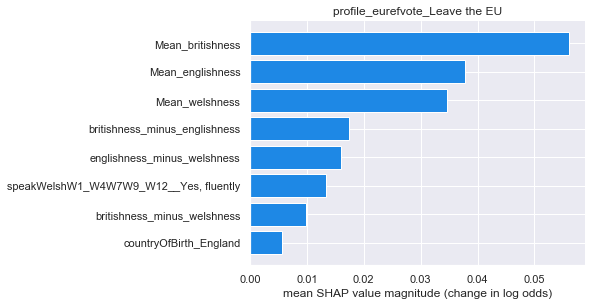

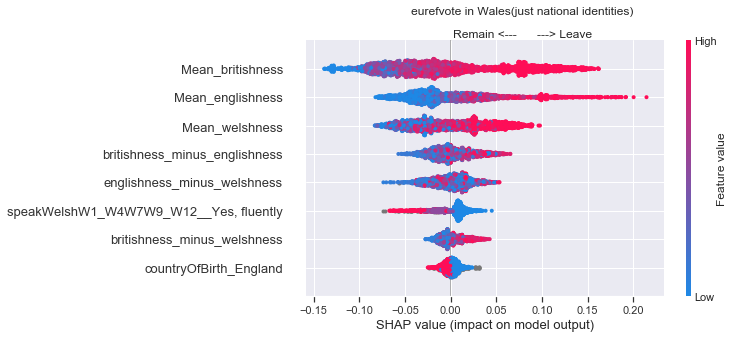

Wall time: 30.3 s


In [43]:
%%time
colname = "eurefvote in Wales(just national identities)"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
xgboost_run(subdir=colname,min_features = min(BES_reduced_with_na.shape[1]-1,8),
           title = colname+"\n\nRemain <---      ---> Leave")

In [32]:
# BES_reduced_with_na["profile_eurefvote_Leave the EU"]

0        1.0
1        1.0
2        1.0
3        NaN
4        NaN
5        1.0
6        0.0
7        1.0
8        0.0
9        0.0
10       1.0
11       NaN
12       NaN
13       1.0
14       1.0
15       NaN
16       1.0
17       0.0
18       0.0
19       NaN
20       NaN
21       0.0
22       1.0
23       0.0
24       NaN
25       NaN
26       NaN
27       NaN
28       1.0
29       0.0
        ... 
68595    NaN
68596    NaN
68597    NaN
68598    1.0
68599    NaN
68600    NaN
68601    NaN
68602    NaN
68603    1.0
68604    NaN
68605    0.0
68606    1.0
68607    NaN
68608    1.0
68609    1.0
68610    0.0
68611    1.0
68612    NaN
68613    NaN
68614    1.0
68615    NaN
68616    NaN
68617    1.0
68618    1.0
68619    1.0
68620    NaN
68621    1.0
68622    NaN
68623    NaN
68624    0.0
Name: profile_eurefvote_Leave the EU, Length: 68625, dtype: float32

In [84]:
# class, education


search(BES_reduced_with_na,"subjClass|ns_sec|socialgrade|anyUni|profile_education_age|subjectHE|edlevel|countryOfBirth|englishness|welshness|speakWelsh|profile_work_stat|workingStatus").index

Index(['welshnessW1__Very strongly Welsh',
       'englishnessW1__Very strongly English',
       'welshnessW2__Very strongly Welsh',
       'englishnessW2__Very strongly English',
       'englishnessW3__Very strongly English',
       'englishnessW4__Very strongly English',
       'englishnessW7__Very strongly English',
       'anyUniW7__Yes, I graduated from higher education',
       'englishnessW8__Very strongly English',
       'englishnessW9__Very strongly English',
       ...
       'ns_sec_analyticW6W7W8W9_Employers in large organisations and higher managerial',
       'subjClassW2_W4W7W9_Yes, working class',
       'subjClassW2_W4W7W9_Yes, middle class', 'subjClassW2_W4W7W9_No',
       'subjectHEW1W2W3_Humanities, social sciences, psychology or education',
       'subjectHEW1W2W3_Engineering, Mathematics or Natural sciences',
       'subjectHEW1W2W3_Economics or business',
       'subjectHEW1W2W3_I never attended higher education (university etc)',
       'subjectHEW1W2W3_Law', '

In [82]:
# anyUni, profile_education_age, subjectHE, edlevel


search(BES_reduced_with_na,"welsh")

welshnessW1__Very strongly Welsh          3437
welshnessW2__Very strongly Welsh          3564
approveWelshGovtW2__Strongly approve      3445
speakWelshW1_W4W7W9_W12__Yes, fluently    5458
dtype: int64

In [25]:
search(BES_reduced_with_na,"Mean_welshness|Mean_englishness|englishness_minus_welshness|britishness_minus_englishness|britishness_minus_welshness")

Mean_welshness                    5623
Mean_englishness                 68010
englishness_minus_welshness       5610
britishness_minus_englishness    67961
britishness_minus_welshness      67961
dtype: int64

In [10]:
Welshness = amalgamate_waves(BES_Panel,"welshness")
Englishness = amalgamate_waves(BES_Panel,"englishness")
Britishness = amalgamate_waves(BES_Panel,"britishness")
Scottishness = amalgamate_waves(BES_Panel,"scottishness")

ResidentInScotland = BES_Panel["country"]=="Scotland"
ResidentInWales = BES_Panel["country"]=="Wales"

Amalgamating variables: 
{1: 'welshnessW1', 2: 'welshnessW2', 3: 'welshnessW3', 4: 'welshnessW4', 7: 'welshnessW7', 8: 'welshnessW8', 9: 'welshnessW9', 10: 'welshnessW10', 11: 'welshnessW11', 12: 'welshnessW12', 13: 'welshnessW13'} ['welshnessW1', 'welshnessW2', 'welshnessW3', 'welshnessW4', 'welshnessW7', 'welshnessW8', 'welshnessW9', 'welshnessW10', 'welshnessW11', 'welshnessW12', 'welshnessW13']
Amalgamating variables: 
{1: 'englishnessW1', 2: 'englishnessW2', 3: 'englishnessW3', 4: 'englishnessW4', 7: 'englishnessW7', 8: 'englishnessW8', 9: 'englishnessW9', 10: 'englishnessW10', 11: 'englishnessW11', 12: 'englishnessW12', 13: 'englishnessW13'} ['englishnessW1', 'englishnessW2', 'englishnessW3', 'englishnessW4', 'englishnessW7', 'englishnessW8', 'englishnessW9', 'englishnessW10', 'englishnessW11', 'englishnessW12', 'englishnessW13']
Amalgamating variables: 
{1: 'britishnessW1', 2: 'britishnessW2', 3: 'britishnessW3', 4: 'britishnessW4', 7: 'britishnessW7', 8: 'britishnessW8', 9: 'br

In [ ]:
# Welshness_num = amalgamate_waves(BES_reduced_with_na,"welshness")
# Englishness_num = amalgamate_waves(BES_reduced_with_na,"englishness")
# Britishness_num = amalgamate_waves(BES_reduced_with_na,"britishness")
# # Scottishness_num = amalgamate_waves(BES_reduced_with_na,"scottishness")

In [23]:
Mean_welshness = BES_Panel[search(BES_Panel,"welshness").index].apply(lambda x: x.cat.codes.replace(-1,np.nan).replace(7,np.nan)).mean(axis=1)
Mean_englishness = BES_Panel[search(BES_Panel,"englishness").index].apply(lambda x: x.cat.codes.replace(-1,np.nan).replace(7,np.nan)).mean(axis=1)
Mean_britishness = BES_Panel[search(BES_Panel,"britishness").index].apply(lambda x: x.cat.codes.replace(-1,np.nan).replace(7,np.nan)).mean(axis=1)
Mean_scottishness = BES_Panel[search(BES_Panel,"scottishness").index].apply(lambda x: x.cat.codes.replace(-1,np.nan).replace(7,np.nan)).mean(axis=1)

In [24]:
BES_reduced_with_na["Mean_welshness"] = Mean_welshness
BES_reduced_with_na["Mean_englishness"] = Mean_englishness
BES_reduced_with_na["englishness_minus_welshness"] = Mean_englishness-Mean_welshness
BES_reduced_with_na["britishness_minus_englishness"] = Mean_britishness-Mean_englishness
BES_reduced_with_na["britishness_minus_welshness"] = Mean_britishness-Mean_englishness

BES_reduced_with_na["Mean_britishness"] = Mean_britishness

# Mean_welshness|Mean_englishness|englishness_minus_welshness|britishness_minus_englishness|britishness_minus_welshness



BES_reduced_with_na["Mean_scottishness"] = Mean_scottishness